# Automatic generation of image-captions

Today's tutorial aims at showing you the capabilities that neural networks have when dealing with images and language. We will see how to use some pre-trained neural networks to program our image-caption generator: essentially we will create a simple system which given any image as input, will output a brief description of the image. This system will consist of two neural networks, the first one will be responsible for dealing with the visual part of the problem (called the encoder), while the second one with the linguistic one (called the decoder). We will not train these neural networks ourselves, therefore you will need to download
the already trained weights yourself from the following links:

 * [weights](https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip?dl=0)
 
We will also need a list of words that the neural network will use for creating the captions of the images. 

 * [vocabulary](https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip?dl=0)
 
 ![alt text](images/model.png)

In [41]:
import torch
import matplotlib.pyplot as plt
import numpy as np 
import argparse
import pickle 
import os
from torchvision import transforms 
from build_vocab import Vocabulary
from model import EncoderCNN, DecoderRNN
from PIL import Image

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Step 1: load an image we want to generate a caption for

Write a custom function which given a path to an image loads it with the PIL library.
Explore the type of the object which gets loaded, do you think it is possible to use
such an object as input to a neural network? Why/Why not?

In [43]:
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224,224], Image.LANCZOS)
    
    print(type(image))
    return image

#### Step 2: convert the previously loaded image to a tensor

An Image object cannot be used as input for a neural network. We need in fact to convert it to a tensor and normalize the values of its pixels.

Write a custom function that gets a PIL Image as input, normalizes its pixels and converts the image to a tensor which can be used as input for a neural network.

In [44]:
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])
    
    image = transform(image).unsqueeze(0)
    image_tensor = image.to(device)
    
    print(type(image_tensor))
    
    return image_tensor

#### Step 3: load the vocabulary of words which will be used for creating a caption

The neural network will require a pool of words to choose from to come up with an appropriate caption for an image. You should have already downloaded a pickle file consisting of a vocabulary which you just need to load in the coming function.

In [45]:
def load_vocabulary(vocab_path):
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)
        
    return vocab

#### Step 4: create the computational graph for the neural architectures we will use

Just for today's tutorial we already provide you with such functions. The neural network consists of two different parts, one denoted as an encoder and one as a decoder, we, therefore, need two different functions. 

In [46]:
def build_encoder(embedding_size):
    encoder = EncoderCNN(embedding_size).eval()  # eval mode (batchnorm uses moving mean/variance)
    encoder = encoder.to(device)
    
    return encoder

In [47]:
def build_decoder(embedding_size, hidden_size, vocab, num_layers):
    decoder = DecoderRNN(embedding_size, hidden_size, len(vocab), num_layers)
    decoder = decoder.to(device)
    return decoder

#### Step 5: load appropriate weights within the computational graph.

The networks which have been created with the previous two functions are not trained, meaning that the captions which we would obtain as output will be very likely garbage. To get better results we need to load the appropriate weights within the computation graph. Write a function which given a computation graph loads the already trained weights that you have downloaded.

In [48]:
def load_weights(model, weights_path):
    model.load_state_dict(torch.load(weights_path))
    return model

#### Step 6: extract meaningful information from the encoder.

A tensor representing an image does not give us much information. We aim at converting such an image to a feature vector that represents the original image in a meaningful way. This corresponds to computing the *forward pass* in the network. Write a function that gets as input an image, the encoder-network and returns a feature vector.

What is the difference between the extracted features and the original input of the network?

In [49]:
def extract_features(processed_image, encoder):
    features = encoder(processed_image)
    print(features)
    return features

#### Step 7: match the extracted features with a potential caption

We now aim at using the features which have been extracted by the encoder-network and use them as input for the decoder-network. The goal is to get from the decoder a set of words which will consists in a potential caption for the image. Write a function which gets the decoder-network and the previously extracted features as input and returns what will later be the words of the caption. 

**TIP**: the decoder will call the .sample() function defined in model.py, so take a look at that python file.

In [50]:
def sample_ids(decoder, features):
    sampled_ids = decoder.sample(features)
    print(sampled_ids)
    sampled_ids = sampled_ids[0].cpu().numpy()
    print(sampled_ids)
    
    return sampled_ids

#### Step 8: convert the output of the decoder to meaningful words

The decoder network does not output directly words but a list of numbers instead.
We now convert these numbers to meaningful words with the following function.

In [51]:
def create_caption(sampled_ids, vocab):
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            return sampled_caption

<class 'PIL.Image.Image'>
<class 'torch.Tensor'>
tensor([[-9.6935e-02,  2.9605e+00, -5.2484e-01,  1.8953e-01, -7.7506e-01,
          5.3080e-01, -8.7414e-01,  5.5875e-02,  6.8203e-01,  8.2988e-01,
         -1.8072e+00,  1.9100e-01, -2.9140e-01, -6.2212e-02,  3.4586e-01,
          2.0405e-02, -1.2416e-03,  1.9875e+00,  6.8697e-03,  3.7107e-01,
         -5.5251e-01,  5.9243e-01, -9.5769e-02, -1.5455e+00,  5.3191e-01,
         -6.3880e-01,  2.3231e+00,  1.8239e-01, -3.4321e-01,  1.1307e+00,
         -2.0427e-01, -1.7190e+00,  1.7797e-01, -1.2956e-01,  6.0929e-01,
          4.0845e-01, -8.3232e-01,  2.9032e-01, -8.1122e-01, -1.2236e-01,
         -1.2634e+00,  8.5137e-02,  2.6966e-01,  2.4604e-01,  2.1038e-01,
          5.3914e-01, -1.3206e-01,  6.8515e-01,  1.4497e-01, -1.8806e-02,
          7.1556e-01, -1.3903e+00, -1.2177e-01, -3.4987e-01, -9.0234e-02,
          2.7905e-01,  1.5031e+00,  4.5215e-01,  2.7694e-01, -2.4072e-01,
          3.9227e-01,  1.4317e-01,  1.5715e-01, -6.0927e-02, -1

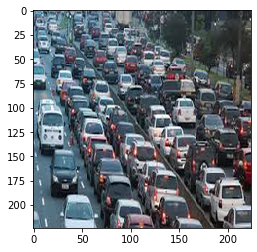

<start> a group of people on a motorcycle in a city . <end>


In [58]:
def main():
    
    # parameters to pass to build_encoder() and build_decoder()
    embedding_size = 256
    hidden_size = 512
    num_layers = 1 
    
    #image = load_image('images/giraffe.png')
    #image = load_image('images/liege.jpg')
    image = load_image('images/bbb.jpg')
    processed_image = preprocess_image(image)
    
    vocab = load_vocabulary('vocabulary/vocab.pkl')     
    
    encoder = build_encoder(embedding_size)    
    decoder = build_decoder(embedding_size, hidden_size, vocab, num_layers)
    
    encoder = load_weights(encoder, 'pretrained_model/encoder-5-3000.pkl')
    decoder = load_weights(decoder, 'pretrained_model/decoder-5-3000.pkl')
    features = extract_features(processed_image, encoder)
    
    sampled_ids = sample_ids(decoder, features)
    tmp_caption = create_caption(sampled_ids, vocab)
    
    final_caption = ' '.join(tmp_caption)

    plt.imshow(np.asarray(image))
    plt.show()
    print(final_caption)
main()